##Market Basket Analysis

#importing section



In [1]:
!pip install mrjob

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import json
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import defaultdict
import time
import pickle
import seaborn as sns
plt.style.use('ggplot')
sns.set()
from mrjob.job import MRJob
from mrjob.step import MRStep

Initialize: firstly we need to delete the directory named "market-basket-analysis" and all its contents recursively if it is already existed

In [7]:
!rm -r AMDs-Market-basket-analysis

rm: cannot remove 'AMDs-Market-basket-analysis': No such file or directory


and now after we need to clone "AMDs-Market-basket-analysis"


In [8]:
!git clone https://github.com/AntoineN21/AMDs-Market-basket-analysis.git

Cloning into 'AMDs-Market-basket-analysis'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 197 (delta 27), reused 0 (delta 0), pack-reused 115
Receiving objects: 100% (197/197), 91.02 KiB | 991.00 KiB/s, done.
Resolving deltas: 100% (61/61), done.


In [9]:
os.environ['KAGGLE_USERNAME'] = "antoinenasra"
os.environ['KAGGLE_KEY'] = "76b8324d7f603ad73a40084d6122d91f"
!kaggle datasets download -d yelp-dataset/yelp-dataset

100% 4.06G/4.07G [00:53<00:00, 47.3MB/s]
100% 4.07G/4.07G [00:53<00:00, 82.3MB/s]


In [10]:
!unzip -j "yelp-dataset.zip" "yelp_academic_dataset_review.json" -d "./market-basket-analysis"

Archive:  yelp-dataset.zip
  inflating: ./market-basket-analysis/yelp_academic_dataset_review.json  


In [11]:
!python3 ./AMDs-Market-basket-analysis/preprocess.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100it [02:43,  1.64s/it]
Number of transactions: 1000000


In order to utilize multiprocessing and overcome the crashing issue when using it directly in the colab, we employed a separate .py file named "preprocess.py" located in the same folder as this notebook. Within the "preprocess.py" file, we performed the processing of buckets and tokenization. As a result, it generated the "transactions.pkl" file, which we subsequently utilize in this notebook.

In [12]:
# Load transactions from a file
transactions = []
with open('transactions.pkl', 'rb') as f:
    transactions = pickle.load(f)

In [28]:
import pickle as pkl

# Load the transactions from the pickle file
with open('transactions.pkl', 'rb') as f:
    transactions = pkl.load(f)

# Display a small portion of the data
num_samples = 5
sample_data = transactions[:num_samples]
for i, transaction in enumerate(sample_data, start=1):
    print(f"Transaction {i}: {transaction}")

Transaction 1: ['decide', 'eat', 'aware', 'going', 'take', 'hours', 'beginning', 'end', 'tried', 'multiple', 'times', 'want', 'like', 'locations', 'nj', 'never', 'bad', 'experience', 'food', 'good', 'takes', 'long', 'time', 'come', 'waitstaff', 'young', 'usually', 'pleasant', 'many', 'experiences', 'spent', 'way', 'long', 'waiting', 'usually', 'opt', 'another', 'diner', 'restaurant', 'weekends', 'order', 'done', 'quicker']
Transaction 2: ['taken', 'lot', 'spin', 'classes', 'years', 'nothing', 'compares', 'classes', 'body', 'cycle', 'nice', 'clean', 'space', 'amazing', 'bikes', 'welcoming', 'motivating', 'instructors', 'every', 'class', 'top', 'notch', 'work', 'anyone', 'struggles', 'fit', 'workouts', 'online', 'scheduling', 'system', 'makes', 'easy', 'plan', 'ahead', 'need', 'line', 'way', 'advanced', 'like', 'many', 'gyms', 'make', 'way', 'write', 'review', 'without', 'giving', 'russell', 'owner', 'body', 'cycle', 'shout', 'russell', 'passion', 'fitness', 'cycling', 'evident', 'desire

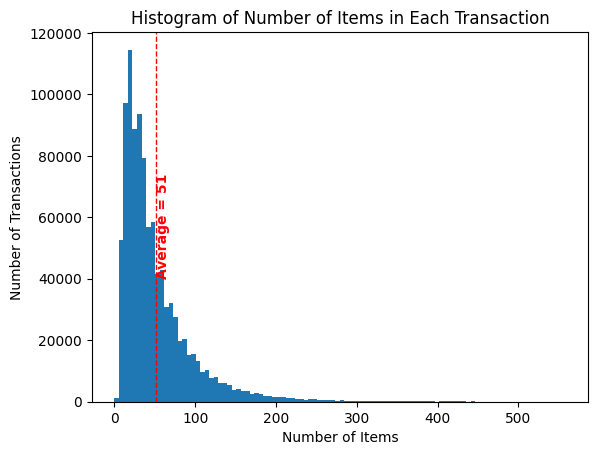

In [29]:
num_items = [len(t) for t in transactions]

plt.hist(num_items, bins=100)
plt.xlabel('Number of Items')
plt.ylabel('Number of Transactions')
plt.title('Histogram of Number of Items in Each Transaction')
#Drawing a vertical line at the average number of items
plt.axvline(int(np.mean(num_items)), color='red', linestyle='dashed', linewidth=1)
#Displaying the average number of items on the x-axis
plt.text(int(np.mean(num_items)), 40000, 'Average = {:d}'.format(int(np.mean(num_items))), rotation=90, va='bottom', color='red', fontsize=10, fontweight='bold')
plt.show()

#Analyze Market Basket

#FP-Growth Algorithm

Define the FPNode Class

In [ ]:
class FPNode:
    def __init__(self, item=None, count=1, parent=None):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = defaultdict(FPNode)  # Use defaultdict to automatically create child nodes

    def increment_count(self):
        self.count += 1


Define the construct_FP_tree function

In [ ]:
def construct_FP_tree(transactions, min_support):
    item_counts = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            item_counts[item] += 1

    # Filter out infrequent items
    item_counts = {item: count for item, count in item_counts.items() if count >= min_support}

    # Sort items by frequency
    frequent_items = sorted(item_counts.keys(), key=lambda item: item_counts[item], reverse=True)

    root = FPNode(None, 0, None)

    # Construct the FP-Tree
    for transaction in transactions:
        # Keep only frequent items and sort them
        transaction = [item for item in transaction if item in frequent_items]
        transaction.sort(key=lambda item: item_counts[item], reverse=True)

        # Traverse the FP-Tree, updating or creating nodes
        current_node = root
        for item in transaction:
            if item in current_node.children:
                current_node.children[item].increment_count()
            else:
                current_node.children[item] = FPNode(item, 1, current_node)
            current_node = current_node.children[item]

    return root, frequent_items, item_counts

Define the mine_frequent_itemsets function

In [ ]:

def mine_frequent_itemsets(root, min_support):
    frequent_itemsets = []

    def find_support(itemset):
        """Find the support of an itemset by checking the minimum support of its items in the tree."""
        return min([item_counts[item] for item in itemset])

    def mine_subtree(node, suffix):
        """Recursively mine the tree."""
        for item, child_node in node.children.items():
          if item not in suffix: #check
            new_suffix = suffix + [item]
            support = find_support(new_suffix)
            if support >= min_support:
                frequent_itemsets.append((new_suffix, support))
                mine_subtree(child_node, new_suffix)

    mine_subtree(root, [])
    return frequent_itemsets





In [ ]:
def get_item_counts_from_transactions(transactions, min_support):
    item_counts = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            item_counts[item] += 1

    # Filter out items below the minimum support threshold
    return {item: count for item, count in item_counts.items() if count >= min_support}



Define the generate_association_rules function

In [ ]:
from itertools import combinations

def generate_association_rules(frequent_itemsets, item_counts, min_confidence):
    association_rules = []

    def get_itemset_support(itemset):
        """Get the support of the itemset, defined as the minimum support of its items."""
        return min([item_counts.get(item, 0) for item in itemset])

    for itemset, itemset_support in frequent_itemsets:
        if len(itemset) < 2:
            continue

        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent_support = get_itemset_support(antecedent)

                if antecedent_support == 0:
                    continue

                consequent = tuple(set(itemset) - set(antecedent))
                confidence = itemset_support / antecedent_support

                if confidence >= min_confidence:
                    association_rules.append((antecedent, consequent, itemset_support, confidence))

    return association_rules



 Construct the FP-Tree and mine frequent itemsets

In [ ]:

# Define the number of transactions to test
num_transactions_to_test = 75

# Slice the transactions dataset
test_transactions = transactions[:num_transactions_to_test]

# Define minimum support and confidence thresholds
min_support = 5
min_confidence = 0.8

# Construct the FP-Tree with the sliced dataset
root, frequent_items, item_counts = construct_FP_tree(test_transactions, min_support)

# Mine the frequent itemsets from the FP-Tree
frequent_itemsets = mine_frequent_itemsets(root, min_support)
print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
print("Some frequent itemsets:", frequent_itemsets[:10])  # Display the first 10

# Generate association rules from the frequent itemsets (if needed)
association_rules = generate_association_rules(frequent_itemsets, item_counts, min_confidence)
print(f"Number of association rules: {len(association_rules)}")
print("Some association rules:", association_rules[:10])  # Display the first 10


Number of frequent itemsets: 234
Some frequent itemsets: [(['good'], 39), (['good', 'food'], 35), (['good', 'food', 'like'], 31), (['good', 'food', 'like', 'time'], 19), (['good', 'food', 'like', 'time', 'restaurant'], 15), (['good', 'food', 'like', 'time', 'restaurant', 'going'], 12), (['good', 'food', 'like', 'time', 'restaurant', 'going', 'way'], 12), (['good', 'food', 'like', 'time', 'restaurant', 'going', 'way', 'want'], 11), (['good', 'food', 'like', 'time', 'restaurant', 'going', 'way', 'want', 'experience'], 11), (['good', 'food', 'like', 'time', 'restaurant', 'going', 'way', 'want', 'experience', 'many'], 11)]
Number of association rules: 78522
Some association rules: [(('good',), ('food',), 35, 0.8974358974358975), (('food',), ('good',), 35, 1.0), (('food',), ('good', 'like'), 31, 0.8857142857142857), (('like',), ('food', 'good'), 31, 1.0), (('good', 'food'), ('like',), 31, 0.8857142857142857), (('good', 'like'), ('food',), 31, 1.0), (('food', 'like'), ('good',), 31, 1.0), ((

 Print the frequent itemsets and association rules

In [ ]:
print("Frequent Itemsets:")
count = 0
for itemset, support in frequent_itemsets:
    if count < 10:
        print(itemset, "Support:", support)
        count += 1
    else:
        break

print("\nAssociation Rules:")
count = 0
for antecedent, consequent, support, confidence in association_rules:
    if count < 10:
        print("Antecedent:", antecedent, "Consequent:", consequent, "Support:", support, "Confidence:", confidence)
        count += 1
    else:
        break

Frequent Itemsets:
['good'] Support: 39
['good', 'food'] Support: 35
['good', 'food', 'like'] Support: 31
['good', 'food', 'like', 'time'] Support: 19
['good', 'food', 'like', 'time', 'restaurant'] Support: 15
['good', 'food', 'like', 'time', 'restaurant', 'going'] Support: 12
['good', 'food', 'like', 'time', 'restaurant', 'going', 'way'] Support: 12
['good', 'food', 'like', 'time', 'restaurant', 'going', 'way', 'want'] Support: 11
['good', 'food', 'like', 'time', 'restaurant', 'going', 'way', 'want', 'experience'] Support: 11
['good', 'food', 'like', 'time', 'restaurant', 'going', 'way', 'want', 'experience', 'many'] Support: 11

Association Rules:
Antecedent: ('good',) Consequent: ('food',) Support: 35 Confidence: 0.8974358974358975
Antecedent: ('food',) Consequent: ('good',) Support: 35 Confidence: 1.0
Antecedent: ('food',) Consequent: ('good', 'like') Support: 31 Confidence: 0.8857142857142857
Antecedent: ('like',) Consequent: ('food', 'good') Support: 31 Confidence: 1.0
Antecedent

--------------------------------------------------------------

#PCY Algorithem

>



Define PCY algorithem

In [10]:


def PCY_algorithm(transactions, minimum_support, size_of_hash_table):
    # Initial pass - Count individual items
    count_of_single_items = {}
    for transaction in transactions:
        for item in transaction:
            if item in count_of_single_items:
                count_of_single_items[item] += 1
            else:
                count_of_single_items[item] = 1

    # Identify items that meet the minimum support threshold
    items_meeting_min_support = {
        item for item, count in count_of_single_items.items() if count >= minimum_support
    }

    # Second pass - Identify frequent pairs and triplets
    counts_of_candidates = {}
    hash_table = np.zeros(size_of_hash_table, dtype=int)

    # Iterate through each transaction
    for transaction in tqdm(transactions):
        transaction_items = set(transaction)

        # Generate all possible pairs from the transaction
        possible_pairs = combinations(transaction_items, 2)
        frequent_pairs = [
            (item1, item2) for item1, item2 in possible_pairs
            if item1 in items_meeting_min_support and item2 in items_meeting_min_support
        ]

        # Count these pairs both in the hash table and separately
        for pair in frequent_pairs:
            hash_index = hash(pair) % size_of_hash_table
            hash_table[hash_index] += 1
            counts_of_candidates[pair] = counts_of_candidates.get(pair, 0) + 1

        # Similarly, generate and count all possible triplets
        possible_triplets = combinations(transaction_items, 3)
        frequent_triplets = [
            (item1, item2, item3) for item1, item2, item3 in possible_triplets
            if (item1, item2) in frequent_pairs and
               (item1, item3) in frequent_pairs and
               (item2, item3) in frequent_pairs
        ]

        for triplet in frequent_triplets:
            hash_index = hash(triplet) % size_of_hash_table
            hash_table[hash_index] += 1
            counts_of_candidates[triplet] = counts_of_candidates.get(triplet, 0) + 1

    # Select itemsets that are frequent according to both minimum support and hash table counts
    frequent_itemsets = [
        (itemset, count) for itemset, count in counts_of_candidates.items()
        if count >= minimum_support and hash_table[hash(itemset) % size_of_hash_table] >= minimum_support
    ]

    return frequent_itemsets




In [13]:
# Number of transactions to consider for the test
num_transactions_to_test = 1000

# Parameters for the PCY algorithm
minimum_support_threshold = 100
size_of_hash_table = 10000

# Execute the PCY algorithm with a subset of transactions
# (first 1000 transactions in this case)
tested_frequent_itemsets = PCY_algorithm(transactions[:num_transactions_to_test],
                                         minimum_support_threshold,
                                         size_of_hash_table)

# Display the frequent itemsets found in the test
print("Frequent Itemsets:")
for itemset in tested_frequent_itemsets[:20]:
    print(itemset)

# Write all the frequent itemsets to a file
with open('/content/AMDs-Market-basket-analysis/frequent_itemsets.txt', 'w') as file:
    for itemset in tested_frequent_itemsets:
        file.write(f"{itemset}\n")


100%|██████████| 1000/1000 [06:47<00:00,  2.45it/s]

Frequent Itemsets:
(('good', 'food'), 167)
(('good', 'place'), 139)
(('great', 'place'), 113)
(('good', 'service'), 102)
(('service', 'food'), 143)
(('like', 'place'), 102)
(('food', 'place'), 106)
(('great', 'food'), 128)


In [14]:
from itertools import combinations

def calculate_itemset_support(itemset, all_transactions):
    """
    Calculate the support for a given itemset within a collection of transactions.

    Parameters:
    itemset (tuple): The itemset for which support is to be calculated.
    all_transactions (list): A list of all transactions (each transaction is a set of items).

    Returns:
    float: The support value for the given itemset.
    """
    occurrence_count = sum(set(itemset).issubset(transaction) for transaction in all_transactions)
    return occurrence_count / len(all_transactions)

def generate_association_rules(frequent_itemsets, minimum_confidence, all_transactions):
    """
    Generate association rules from frequent itemsets.

    Parameters:
    frequent_itemsets (list): A list of tuples, where each tuple contains a frequent itemset and its count.
    minimum_confidence (float): The minimum confidence threshold for the rules.
    all_transactions (list): A list of all transactions.

    Returns:
    list: A list of tuples representing the association rules. Each tuple contains the antecedent, consequent, support, and confidence of the rule.
    """
    rules = []
    for itemset, _ in frequent_itemsets:
        if len(itemset) > 1:
            for subset in generate_all_subsets(itemset):
                antecedent = subset
                consequent = tuple(item for item in itemset if item not in antecedent)
                support_of_antecedent = calculate_itemset_support(antecedent, all_transactions)
                support_of_itemset = calculate_itemset_support(itemset, all_transactions)
                if support_of_antecedent > 0:
                    confidence = support_of_itemset / support_of_antecedent
                    if confidence >= minimum_confidence:
                        rules.append((antecedent, consequent, support_of_itemset, confidence))
    return rules

def generate_all_subsets(itemset):
    """
    Generate all non-empty proper subsets of an itemset.

    Parameters:
    itemset (tuple): The itemset from which subsets are generated.

    Returns:
    list: A list of subsets of the itemset.
    """
    all_subsets = []
    for i in range(1, len(itemset)):
        all_subsets.extend(combinations(itemset, i))
    return all_subsets


In [15]:
# Set the minimum confidence threshold for association rules
minimum_confidence_threshold = 0.3

# Generate association rules from the frequent itemsets
# We limit the transactions to the first 100 for this analysis
generated_association_rules = generate_association_rules(tested_frequent_itemsets,
                                                        minimum_confidence_threshold,
                                                        transactions[:100])

# Writing the generated association rules to a file
with open('/content/AMDs-Market-basket-analysis/association_rules.txt', 'w') as file:
    for rule in generated_association_rules:
        antecedent, consequent, support_value, confidence_value = rule
        file.write(f"Antecedent: {antecedent}\n")
        file.write(f"Consequent: {consequent}\n")
        file.write(f"Support: {support_value:.4f}\n")
        file.write(f"Confidence: {confidence_value:.4f}\n")
        file.write("---\n")


# Print the generated association rules with their metrics
print("Generated Association Rules:")
for rule in generated_association_rules[:20]:
    antecedent, consequent, support_value, confidence_value = rule
    print(f"Antecedent: {antecedent}")
    print(f"Consequent: {consequent}")
    print(f"Support: {support_value:.4f}")  # formatted for precision
    print(f"Confidence: {confidence_value:.4f}")  # formatted for precision
    print("---")



Generated Association Rules:
Antecedent: ('good',)
Consequent: ('food',)
Support: 0.1500
Confidence: 0.4688
---
Antecedent: ('food',)
Consequent: ('good',)
Support: 0.1500
Confidence: 0.3846
---
Antecedent: ('place',)
Consequent: ('good',)
Support: 0.0900
Confidence: 0.3103
---
Antecedent: ('great',)
Consequent: ('place',)
Support: 0.1200
Confidence: 0.3333
---
Antecedent: ('place',)
Consequent: ('great',)
Support: 0.1200
Confidence: 0.4138
---
Antecedent: ('service',)
Consequent: ('food',)
Support: 0.1400
Confidence: 0.6667
---
Antecedent: ('food',)
Consequent: ('service',)
Support: 0.1400
Confidence: 0.3590
---
Antecedent: ('food',)
Consequent: ('place',)
Support: 0.1400
Confidence: 0.3590
---
Antecedent: ('place',)
Consequent: ('food',)
Support: 0.1400
Confidence: 0.4828
---


#PCY using Map Reduce

In [3]:
!python3 AMDs-Market-basket-analysis/PCY_MAP_REDUCE.py

Number of transactions: 1000000
Using only the first 500000 transactions
Processing subset size: 1000
Number of worker processes: 2
Map Phase: 100% 1/1 [00:00<00:00,  7.08it/s]
Reduce Phase: 0it [00:00, ?it/s]
Time taken: 0.39853501319885254

Processing subset size: 10000
Number of worker processes: 2
Map Phase: 100% 1/1 [00:02<00:00,  2.15s/it]
Reduce Phase: 0it [00:00, ?it/s]
Time taken: 2.575181245803833

Processing subset size: 100000
Number of worker processes: 2
Map Phase: 100% 10/10 [00:21<00:00,  2.14s/it]
Reduce Phase: 100% 7/7 [00:00<00:00, 203889.78it/s]
Time taken: 24.043862104415894

Processing subset size: 200000
Number of worker processes: 2
Map Phase: 100% 20/20 [01:21<00:00,  4.08s/it]
Reduce Phase: 100% 77/77 [00:00<00:00, 1392075.03it/s]
Time taken: 85.69171738624573

Number of frequent itemsets: 77


#Benchmark for PCY

In [5]:
# Load pkl file of inference time
import pickle
with open('pcy_times.pkl', 'rb') as f:
    pcy_times = pickle.load(f)
    print("PCY Times:")
print(pcy_times)

PCY Times:
[0.39853501319885254, 2.575181245803833, 24.043862104415894, 85.69171738624573]


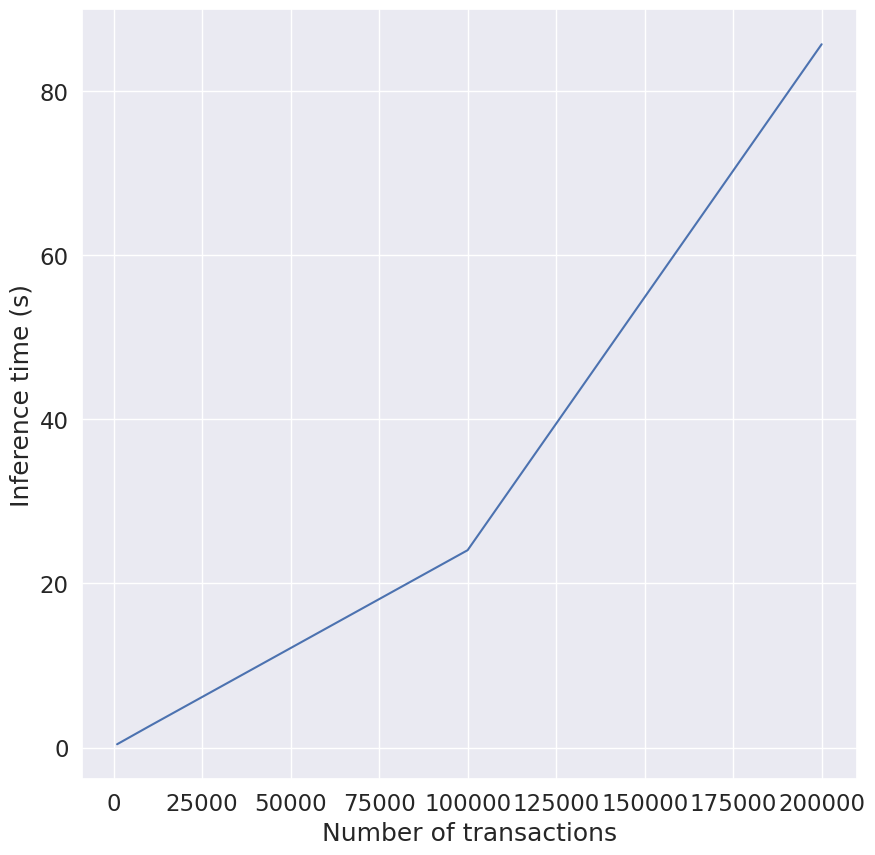

In [6]:
x = [1000, 10000, 100000, 200000]

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
plt.plot(x, pcy_times)
plt.xlabel('Number of transactions')
plt.ylabel('Inference time (s)')
plt.ScalarFormatter(useMathText=True)

plt.show()